In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm  

In [2]:
unlabeled_set_size = 0.25
labeled_train_absolute_set_size = 0.1
labeled_test_absolute_set_size = round(1 - (labeled_train_absolute_set_size + unlabeled_set_size), 2)

labeled_train_relative_set_size = round((labeled_train_absolute_set_size / (1 - unlabeled_set_size)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

In [3]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')
os.makedirs('best_models', exist_ok=True)
model_save_path = \
    os.path.join('best_models', f'h1_{int(unlabeled_set_size*100)}-{int(labeled_train_absolute_set_size*100)}-{int(labeled_test_absolute_set_size*100)}_VAE.pth')
encoder_save_path = \
    os.path.join('best_models', f'h1_{int(unlabeled_set_size*100)}-{int(labeled_train_absolute_set_size*100)}-{int(labeled_test_absolute_set_size*100)}_EncoderVAE.pth')

In [4]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256*14*14, z_dim=32):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(256, 14, 14)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        h_decoded = self.fc3(z)
        x_reconstructed = self.decoder(h_decoded)
        return x_reconstructed, mu, logvar

def loss_function(reconstructed_x, x, mu, logvar):
    MSE = F.mse_loss(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [5]:
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [6]:

base_dir = 'Plant_leave_diseases_dataset/original'
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])


indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [7]:
#Obtenemos el 20% de los datos 
val_indices, train_indices = train_test_split(indices, test_size=unlabeled_set_size, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
val_labels = [labels[i] for i in val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
_, val_indices = train_test_split(val_indices, test_size=labeled_test_relative_set_size, stratify=val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, train_indices)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 15372
Número de imágenes en el conjunto de validación: 15372


In [9]:
def train_vae(vae, train_loader, val_loader, optimizer, device, num_epochs=10, patience=5, model_save_path='best_vae.pth', encoder_save_path='best_encoder.pth'):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    vae.train()
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        vae.train()  # Asegurarse de que el modelo esté en modo de entrenamiento
        
        # Añadir la barra de progreso para el epoch actual
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for batch in train_loader:
                images, _ = batch
                images = images.to(device)
                optimizer.zero_grad()
                reconstructed_images, mu, logvar = vae(images)
                loss = loss_function(reconstructed_images, images, mu, logvar)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                pbar.update(1)
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        
        # Paso de validación
        vae.eval()  # Asegurarse de que el modelo esté en modo de evaluación
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images, _ = batch
                images = images.to(device)
                reconstructed_images, mu, logvar = vae(images)
                MSE = F.mse_loss(reconstructed_images, images, reduction='sum')
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = MSE + KLD
                total_val_loss += loss.item()
                print(f'Batch MSE: {MSE.item()}, KLD: {KLD.item()}, Total Loss: {loss.item()}')
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        
        # Verificar si el modelo actual es el mejor
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Guardar el modelo completo de la VAE
            torch.save(vae.state_dict(), model_save_path)
            # Guardar la parte del encoder de la VAE
            torch.save(vae.encoder.state_dict(), encoder_save_path)
            print(f'\nMejor modelo guardado con pérdida de validación: {avg_val_loss:.4f}')
        else:
            epochs_no_improve += 1
        
        # Verificar early stopping
        if epochs_no_improve >= patience:
            print(f'\nEarly stopping activado. No ha mejorado en {patience} épocas.')
            break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

In [10]:
def load_best_vae(vae, model_save_path='best_vae.pth', encoder_save_path='best_encoder.pth'):
    vae.load_state_dict(torch.load(model_save_path))
    vae.encoder.load_state_dict(torch.load(encoder_save_path))
    vae.eval()



In [11]:
def evaluate_vae(vae, dataloader, device):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            images, _ = batch
            images = images.to(device)
            reconstructed_images, mu, logvar = vae(images)
            loss = loss_function(reconstructed_images, images, mu, logvar)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Pérdida promedio: {avg_loss:.4f}')

    # Visualizar algunas de las imágenes originales y reconstruidas
    images, _ = next(iter(dataloader))
    images = images.to(device)
    reconstructed_images, _, _ = vae(images)
    
    images = images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()
    
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        # Imágenes originales
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        
        # Imágenes reconstruidas
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    
    axes[0, 0].set_title('Imágenes Originales')
    axes[1, 0].set_title('Imágenes Reconstruidas')
    plt.show()

Usando dispositivo: mps


Epoch 1/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.39batch/s]


Batch MSE: 13787.2314453125, KLD: 277.2635498046875, Total Loss: 14064.4951171875
Batch MSE: 15043.115234375, KLD: 262.29180908203125, Total Loss: 15305.4072265625
Batch MSE: 22864.359375, KLD: 227.53057861328125, Total Loss: 23091.890625
Batch MSE: 14920.326171875, KLD: 239.51785278320312, Total Loss: 15159.84375
Batch MSE: 20920.7265625, KLD: 204.02931213378906, Total Loss: 21124.755859375
Batch MSE: 22081.359375, KLD: 180.15298461914062, Total Loss: 22261.51171875
Batch MSE: 12487.3134765625, KLD: 159.82052612304688, Total Loss: 12647.1337890625
Batch MSE: 15171.3544921875, KLD: 210.20477294921875, Total Loss: 15381.5595703125
Batch MSE: 13204.265625, KLD: 263.0035705566406, Total Loss: 13467.26953125
Batch MSE: 14293.31640625, KLD: 191.671142578125, Total Loss: 14484.9873046875
Batch MSE: 30322.62890625, KLD: 216.68072509765625, Total Loss: 30539.310546875
Batch MSE: 13829.62109375, KLD: 211.44410705566406, Total Loss: 14041.0654296875
Batch MSE: 13898.28515625, KLD: 191.1857604980

Epoch 2/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.41batch/s]


Batch MSE: 13848.173828125, KLD: 251.4656982421875, Total Loss: 14099.6396484375
Batch MSE: 14810.6484375, KLD: 251.9609832763672, Total Loss: 15062.609375
Batch MSE: 22648.4140625, KLD: 227.755126953125, Total Loss: 22876.169921875
Batch MSE: 14774.650390625, KLD: 240.27996826171875, Total Loss: 15014.9306640625
Batch MSE: 20429.3828125, KLD: 205.46807861328125, Total Loss: 20634.8515625
Batch MSE: 21690.92578125, KLD: 186.81640625, Total Loss: 21877.7421875
Batch MSE: 12421.8388671875, KLD: 154.40953063964844, Total Loss: 12576.248046875
Batch MSE: 14939.2890625, KLD: 201.70358276367188, Total Loss: 15140.9921875
Batch MSE: 12874.7724609375, KLD: 253.27943420410156, Total Loss: 13128.0517578125
Batch MSE: 14109.1298828125, KLD: 192.6138916015625, Total Loss: 14301.744140625
Batch MSE: 29936.76171875, KLD: 211.34844970703125, Total Loss: 30148.109375
Batch MSE: 13678.7958984375, KLD: 212.71197509765625, Total Loss: 13891.5078125
Batch MSE: 13775.7353515625, KLD: 183.90847778320312, To

Epoch 3/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.42batch/s]


Batch MSE: 13503.3251953125, KLD: 270.0194091796875, Total Loss: 13773.3447265625
Batch MSE: 14660.2626953125, KLD: 280.2299499511719, Total Loss: 14940.4921875
Batch MSE: 22676.337890625, KLD: 253.7439727783203, Total Loss: 22930.08203125
Batch MSE: 14607.5341796875, KLD: 273.68572998046875, Total Loss: 14881.2197265625
Batch MSE: 20385.26953125, KLD: 224.66848754882812, Total Loss: 20609.9375
Batch MSE: 21589.462890625, KLD: 217.3557586669922, Total Loss: 21806.818359375
Batch MSE: 12467.908203125, KLD: 172.6116485595703, Total Loss: 12640.51953125
Batch MSE: 14825.1630859375, KLD: 221.26348876953125, Total Loss: 15046.4267578125
Batch MSE: 12678.6669921875, KLD: 285.94549560546875, Total Loss: 12964.6123046875
Batch MSE: 14091.767578125, KLD: 213.733642578125, Total Loss: 14305.5009765625
Batch MSE: 29846.328125, KLD: 235.89730834960938, Total Loss: 30082.224609375
Batch MSE: 13516.62890625, KLD: 244.5808868408203, Total Loss: 13761.2099609375
Batch MSE: 13779.4169921875, KLD: 203.8

Epoch 4/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.48batch/s]


Batch MSE: 13497.908203125, KLD: 263.5582580566406, Total Loss: 13761.466796875
Batch MSE: 14534.3515625, KLD: 271.3294677734375, Total Loss: 14805.6806640625
Batch MSE: 22597.642578125, KLD: 242.94534301757812, Total Loss: 22840.587890625
Batch MSE: 14548.5244140625, KLD: 267.10919189453125, Total Loss: 14815.6337890625
Batch MSE: 20311.189453125, KLD: 216.928955078125, Total Loss: 20528.119140625
Batch MSE: 21443.56640625, KLD: 207.02703857421875, Total Loss: 21650.59375
Batch MSE: 12424.99609375, KLD: 158.96897888183594, Total Loss: 12583.96484375
Batch MSE: 14791.7734375, KLD: 213.06689453125, Total Loss: 15004.83984375
Batch MSE: 12687.736328125, KLD: 284.49847412109375, Total Loss: 12972.234375
Batch MSE: 14044.5546875, KLD: 202.49896240234375, Total Loss: 14247.0537109375
Batch MSE: 29685.77734375, KLD: 232.86497497558594, Total Loss: 29918.642578125
Batch MSE: 13474.544921875, KLD: 234.51609802246094, Total Loss: 13709.060546875
Batch MSE: 13775.384765625, KLD: 190.6259765625, 

Epoch 5/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.47batch/s]


Batch MSE: 13414.97265625, KLD: 272.9599914550781, Total Loss: 13687.9326171875
Batch MSE: 14567.0322265625, KLD: 283.0836486816406, Total Loss: 14850.1162109375
Batch MSE: 22567.41015625, KLD: 252.464599609375, Total Loss: 22819.875
Batch MSE: 14482.302734375, KLD: 285.43670654296875, Total Loss: 14767.7392578125
Batch MSE: 20306.271484375, KLD: 220.02365112304688, Total Loss: 20526.294921875
Batch MSE: 21507.02734375, KLD: 212.06814575195312, Total Loss: 21719.095703125
Batch MSE: 12410.845703125, KLD: 160.64352416992188, Total Loss: 12571.4892578125
Batch MSE: 14769.1767578125, KLD: 218.25579833984375, Total Loss: 14987.4326171875
Batch MSE: 12698.97265625, KLD: 286.17694091796875, Total Loss: 12985.1494140625
Batch MSE: 14005.44921875, KLD: 205.36581420898438, Total Loss: 14210.8154296875
Batch MSE: 29714.77734375, KLD: 243.22488403320312, Total Loss: 29958.001953125
Batch MSE: 13457.921875, KLD: 241.07537841796875, Total Loss: 13698.9970703125
Batch MSE: 13811.1025390625, KLD: 192

Epoch 6/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.51batch/s]


Batch MSE: 13322.83984375, KLD: 259.2548522949219, Total Loss: 13582.0947265625
Batch MSE: 14535.123046875, KLD: 268.67535400390625, Total Loss: 14803.798828125
Batch MSE: 22525.630859375, KLD: 243.58184814453125, Total Loss: 22769.212890625
Batch MSE: 14390.4384765625, KLD: 274.1578674316406, Total Loss: 14664.5966796875
Batch MSE: 20296.71875, KLD: 211.0618896484375, Total Loss: 20507.78125
Batch MSE: 21243.07421875, KLD: 204.2928466796875, Total Loss: 21447.3671875
Batch MSE: 12421.58984375, KLD: 152.68711853027344, Total Loss: 12574.27734375
Batch MSE: 14725.724609375, KLD: 207.4016571044922, Total Loss: 14933.1259765625
Batch MSE: 12636.736328125, KLD: 278.39373779296875, Total Loss: 12915.1298828125
Batch MSE: 14001.640625, KLD: 196.9283447265625, Total Loss: 14198.5693359375
Batch MSE: 29646.2109375, KLD: 235.96014404296875, Total Loss: 29882.171875
Batch MSE: 13487.986328125, KLD: 233.52923583984375, Total Loss: 13721.515625
Batch MSE: 13739.34375, KLD: 182.09848022460938, Tota

Epoch 7/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.53batch/s]


Batch MSE: 13256.623046875, KLD: 265.4122619628906, Total Loss: 13522.03515625
Batch MSE: 14464.8916015625, KLD: 273.2108154296875, Total Loss: 14738.1025390625
Batch MSE: 22550.1171875, KLD: 244.30618286132812, Total Loss: 22794.423828125
Batch MSE: 14346.0146484375, KLD: 277.9859619140625, Total Loss: 14624.0009765625
Batch MSE: 20218.2421875, KLD: 209.89601135253906, Total Loss: 20428.138671875
Batch MSE: 21286.08984375, KLD: 209.34713745117188, Total Loss: 21495.4375
Batch MSE: 12393.66015625, KLD: 149.99815368652344, Total Loss: 12543.658203125
Batch MSE: 14704.052734375, KLD: 205.96548461914062, Total Loss: 14910.0185546875
Batch MSE: 12618.5400390625, KLD: 284.82086181640625, Total Loss: 12903.361328125
Batch MSE: 13950.732421875, KLD: 192.9187774658203, Total Loss: 14143.6513671875
Batch MSE: 29469.865234375, KLD: 235.90438842773438, Total Loss: 29705.76953125
Batch MSE: 13415.3203125, KLD: 234.41064453125, Total Loss: 13649.73046875
Batch MSE: 13739.009765625, KLD: 182.6634368

Epoch 8/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.46batch/s]


Batch MSE: 13378.2861328125, KLD: 261.82861328125, Total Loss: 13640.115234375
Batch MSE: 14529.4150390625, KLD: 271.1087646484375, Total Loss: 14800.5234375
Batch MSE: 22578.65625, KLD: 240.8516845703125, Total Loss: 22819.5078125
Batch MSE: 14330.79296875, KLD: 278.61981201171875, Total Loss: 14609.4130859375
Batch MSE: 20222.21875, KLD: 204.40286254882812, Total Loss: 20426.62109375
Batch MSE: 21181.8125, KLD: 203.88768005371094, Total Loss: 21385.69921875
Batch MSE: 12387.8994140625, KLD: 143.96054077148438, Total Loss: 12531.8603515625
Batch MSE: 14778.275390625, KLD: 198.723388671875, Total Loss: 14976.9990234375
Batch MSE: 12629.4111328125, KLD: 277.7169189453125, Total Loss: 12907.1279296875
Batch MSE: 13938.11328125, KLD: 186.17095947265625, Total Loss: 14124.2841796875
Batch MSE: 29525.796875, KLD: 234.889892578125, Total Loss: 29760.6875
Batch MSE: 13425.95703125, KLD: 230.68716430664062, Total Loss: 13656.64453125
Batch MSE: 13792.85546875, KLD: 174.76878356933594, Total Lo

Epoch 9/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.50batch/s]


Batch MSE: 13260.634765625, KLD: 259.455322265625, Total Loss: 13520.08984375
Batch MSE: 14444.318359375, KLD: 270.31884765625, Total Loss: 14714.63671875
Batch MSE: 22525.146484375, KLD: 238.75155639648438, Total Loss: 22763.8984375
Batch MSE: 14358.6318359375, KLD: 277.3328552246094, Total Loss: 14635.96484375
Batch MSE: 20217.5625, KLD: 202.8961944580078, Total Loss: 20420.458984375
Batch MSE: 21139.48046875, KLD: 209.56607055664062, Total Loss: 21349.046875
Batch MSE: 12424.65234375, KLD: 146.66258239746094, Total Loss: 12571.314453125
Batch MSE: 14701.6396484375, KLD: 197.449951171875, Total Loss: 14899.08984375
Batch MSE: 12480.232421875, KLD: 273.7066345214844, Total Loss: 12753.939453125
Batch MSE: 13953.087890625, KLD: 187.20314025878906, Total Loss: 14140.291015625
Batch MSE: 29589.455078125, KLD: 237.02127075195312, Total Loss: 29826.4765625
Batch MSE: 13364.7265625, KLD: 232.0079803466797, Total Loss: 13596.734375
Batch MSE: 13757.986328125, KLD: 176.94737243652344, Total L

Epoch 10/10: 100%|██████████| 3843/3843 [01:48<00:00, 35.45batch/s]


Batch MSE: 13286.3056640625, KLD: 249.28274536132812, Total Loss: 13535.5888671875
Batch MSE: 14443.388671875, KLD: 262.66925048828125, Total Loss: 14706.0576171875
Batch MSE: 22563.2578125, KLD: 238.16287231445312, Total Loss: 22801.419921875
Batch MSE: 14291.3974609375, KLD: 278.33782958984375, Total Loss: 14569.7353515625
Batch MSE: 20208.693359375, KLD: 202.80047607421875, Total Loss: 20411.494140625
Batch MSE: 21112.35546875, KLD: 204.82296752929688, Total Loss: 21317.177734375
Batch MSE: 12410.296875, KLD: 144.8171844482422, Total Loss: 12555.1142578125
Batch MSE: 14740.8994140625, KLD: 195.88348388671875, Total Loss: 14936.783203125
Batch MSE: 12564.173828125, KLD: 275.69415283203125, Total Loss: 12839.8681640625
Batch MSE: 13906.03515625, KLD: 189.0744171142578, Total Loss: 14095.109375
Batch MSE: 29450.73046875, KLD: 237.83505249023438, Total Loss: 29688.56640625
Batch MSE: 13473.8818359375, KLD: 228.2136688232422, Total Loss: 13702.095703125
Batch MSE: 13744.953125, KLD: 173.

IndexError: index 4 is out of bounds for axis 0 with size 4

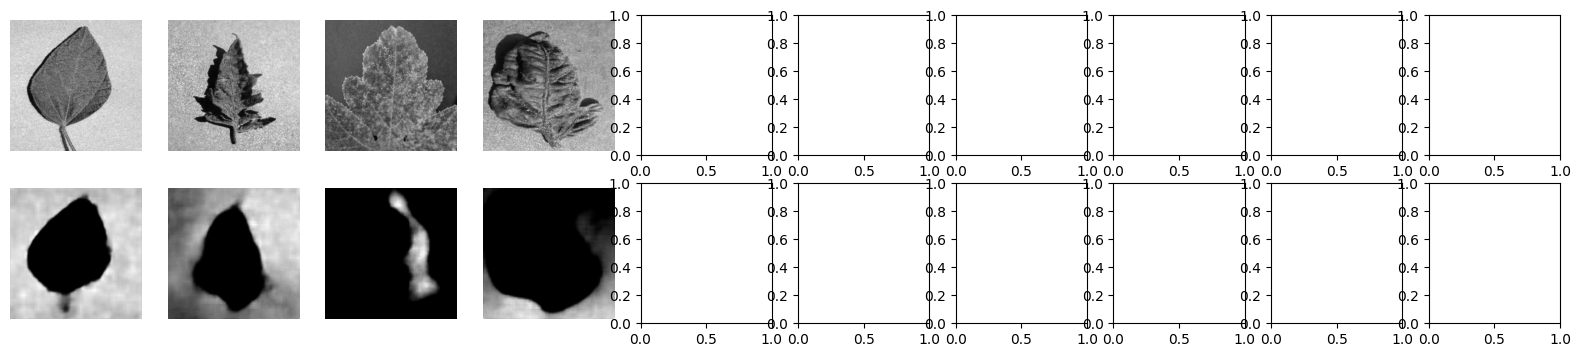

In [12]:
# Determinar el dispositivo
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Usando dispositivo: {device}')

# Definir y entrenar el modelo con lr = 0.001
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

# Entrenar la VAE
train_vae(vae, train_loader, val_loader, optimizer, device, num_epochs=10, patience=5, model_save_path=model_save_path, encoder_save_path=encoder_save_path)

# Cargar el mejor modelo y encoder, y evaluar
load_best_vae(vae, model_save_path=model_save_path, encoder_save_path=encoder_save_path)
evaluate_vae(vae, val_loader, device)